## Requirement 1: Stochatic Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### Stochastic Pricing Environment

In [2]:
class StochasticPricingEnvironment:
    def __init__(self, model='linear', alpha=None, beta=None):
        self.model = model
        self.alpha = alpha
        self.beta = beta
        np.random.seed(42)


    # given settled price and number customer
    # returns a sample of number of sale and profit
    def round(self, price_t, n_costumer_t):
        # number of sale at time t
        number_sale_t = np.random.binomial(n_costumer_t, StochasticPricingEnvironment.generate_probability(self.model, self.alpha, self.beta, price_t))

        return number_sale_t

    # takes as input the selling price -> [0,1]
    # return as output the probability of selling -> [0,1]
    @staticmethod
    def generate_probability(model, a, b, price):
        def isNotNone(s,d):
            if s is None:
                return d
            else:
                return s
        global purchase_probabilities
        if model == 'linear':
            alpha = isNotNone(a, 1) # Intercept
            beta = isNotNone(b, -1)  # Slope
            purchase_probabilities = alpha + beta * price

        elif model == 'logistic':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * price)))

        elif model == 'probit':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = norm.cdf(alpha + beta * price)

        elif model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * price) * np.exp(-price * 5) + price * .10) + .1

        return purchase_probabilities


### Pricing Agent : Gaussian Process Agent with RBF kernel and UCB algorithm

In [3]:
# Radial Basis Function Kernel
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [4]:
class GPUCBAgent:
    def __init__(self, T, minimum_price=0, maximum_price=1, scale=0.1, discretization=None):
        self.T = T
        if(discretization is None):
            # discretization prescribed by theory
            epsilon = T**(-0.33)
            discretization = int(1/epsilon)
        self.minimum_price = minimum_price
        self.maximum_price = maximum_price
        self.arms = np.linspace(minimum_price, maximum_price, discretization)
        self.N_pulls = np.zeros(discretization)
        self.average_bidding_costs = np.zeros(discretization)
        self.average_customer_percentages = np.ones(discretization)
        self.gp = RBFGaussianProcess(scale=scale).fit()
        self.a_t = None
        self.action_hist = []
        self.reward_hist = []
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.t = 0

    def pull_arm(self, verbose=False):
        # play every arm at least once
        if self.t < len(self.arms):
            self.a_t = self.t
            return self.arms[self.a_t],1,self.average_bidding_costs[self.a_t]
        else:
            # averages of GP  +  estimation uncertainty  -> purchase probability
            self.mu_t, self.sigma_t = self.gp.predict(self.arms)
            purchase_probabilities = self.mu_t + self.beta(self.t) * self.sigma_t
            # estimated profit per customer of each price
            estimated_profits_per_customer = purchase_probabilities * self.arms - self.average_bidding_costs
            # estimated total profit of each price
            ucbs = estimated_profits_per_customer * self.average_customer_percentages
            self.a_t = np.argmax(ucbs)
            if(verbose):
                print(purchase_probabilities)
                print(self.arms - self.average_bidding_costs)
                print(estimated_profits_per_customer)
                print(self.average_customer_percentages)
                print(ucbs)
            return self.arms[self.a_t], purchase_probabilities[self.a_t], self.average_bidding_costs[self.a_t]

    def update(self, n_sales_t, n_customers_t, bidding_cost_per_customer_t=0, customer_percentage=1):
        self.N_pulls[self.a_t] += 1
        self.average_bidding_costs[self.a_t] += (bidding_cost_per_customer_t - self.average_bidding_costs[self.a_t])/self.N_pulls[self.a_t]
        # probability of winning customers of arm
        # self.average_customer_percentages[self.a_t] += (customer_percentage - self.average_customer_percentages[self.a_t])/self.N_pulls[self.a_t]
        self.average_customer_percentages[self.a_t] = 0.8*self.average_customer_percentages[self.a_t] + 0.2*customer_percentage
        # purchase probability of arm
        estimated_purchase_probability = 0
        if(n_customers_t != 0):
            estimated_purchase_probability = n_sales_t / n_customers_t
        self.gp = self.gp.fit(self.arms[self.a_t], estimated_purchase_probability)
        self.t += 1
        self.action_hist.append(self.arms[self.a_t])
        self.reward_hist.append((self.arms[self.a_t]-self.minimum_price)*n_sales_t - bidding_cost_per_customer_t*n_customers_t)


In [5]:
# UCB1 agent for performance comparison
class UCB1Agent:
    def __init__(self, T, K=None, range=1):
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t, verbose = False):
        if verbose:
            print(f'updating arm {self.a_t} with reward {r_t} average reward : {self.average_rewards[self.a_t]:.2f} -> {(self.average_rewards[self.a_t] + (r_t - self.average_rewards[self.a_t])/(self.N_pulls[self.a_t]+1)):.2f}')
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Bidding Environment

In [6]:
class SecondPriceAuction:
    def __init__(self, ctrs):
        # ctr = click though rate = lambda * q
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self, bids):
        # sort not by bids, but estimated values
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

    def round(self, bids):
        # given bids, return winner(s) and the estimated values (product of 3 terms : lambda, q, bid) of winner(s)
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [7]:
class UniformBiddingEnvironment:
    def __init__(self, T, n_advertisers, auction, seed=42):
        self.T = T
        self.auction = auction
        self.n_advertisers = n_advertisers
        np.random.seed(seed)
        self.other_bids = np.random.uniform(0, 1, size = (n_advertisers, T))
        self.m_t = self.other_bids.max(axis=0)

    def round(self, round, bid):
        bids_at_round = np.append(self.other_bids[:, round], bid)
        winners, payments_per_click = self.auction.round(bids=bids_at_round)
        return winners, self.m_t[round]

                    # conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)
    # get_clairvoyant_truthful(B, p_t*conversion_probabilities[pricing_agent.a_t])

    def get_clairvoyant_truthful(self, B, my_valuation):
        ## I compute my sequence of utilities at every round
        utility = (my_valuation-self.m_t)*(my_valuation>=self.m_t)
        #   if valuation less than max_bid of the round, no need to participate
        #   if higher, utility is the difference

        ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
        ## In second price auctions, I can find the sequence **greedily**:
        sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
        clairvoyant_utilities = np.zeros(self.T)
        clairvoyant_bids= np.zeros(self.T)
        clairvoyant_payments = np.zeros(self.T)
        c = 0
        i = 0
        #    (enough budget) and (examined all rounds)
        while c <= B-1 and i < self.T and i < np.count_nonzero(utility):
            clairvoyant_bids[sorted_round_utility[i]] = 1  # simply bid 1 because we are in second-price auction
            clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
            clairvoyant_payments[sorted_round_utility[i]] = self.m_t[sorted_round_utility[i]]
            c += self.m_t[sorted_round_utility[i]]  # cost is incremented by second price of that round
            i+=1
        return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

### Bidding Agents

#### Primal-dual algorithm -> Multiplicative Pacing

In [10]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1  # shouldn't this be initialized with 0?
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

#### Alternative Multiplicative Pacing -> continuously updated Rho
Idea behind is that normal MP generally does not deplete budget, so update every round the budget per round

In [11]:
class ContinuousUpdatedRhoMPAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = 1.*self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update(self, f_t, c_t):
      self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                          a_min=0, a_max=1/self.rho)
      self.budget -= c_t
      self.t += 1
      self.rho = self.budget/(self.T-self.t)

#### UCB-like algorithm -> simple UCB

In [12]:
class UCBAgent:
    def __init__(self, valuation, budget, T, K=100, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0

        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.t += 1
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t

#### UCB-like algorithm -> UCB with negative feedback when not winning (lost opportunity)
lost opportunity computed as average utility when winning

In [21]:
class UCBNFAgent:
    def __init__(self, valuation, budget, T, K=None, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.winning_total_reward = 0
        self.won_time = 0
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0

        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
            # if(self.t<50):
            #     print(f'round {self.t} : {ucbs}\n bidded {self.arms[self.a_t]} with ucb={ucbs[self.a_t]}')
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        if(f_t>0):
            self.won_time += 1
            self.winning_total_reward += f_t
        elif(self.t >= self.K):
            f_t = self.winning_total_reward
            if(self.won_time != 0):
                f_t = - self.winning_total_reward / self.won_time

        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

### Simulation

In [12]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

np.random.seed(2)

# product
min_price, max_price = 10, 20
production_cost = 10
price_discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(production_cost, min_price, max_price)  # equals to scaled_min_price

# Pricing Environment and Agent
# Logistic model example
model='logistic'
alpha=0.8
beta=-3
scale=2
TotalDays = 365
pricing_env = StochasticPricingEnvironment(model, alpha, beta)
pricing_agent = GPUCBAgent(TotalDays, scaled_min_price, scaled_max_price, discretization=price_discretization, scale=scale)
n_customers_t = 0        # to be determined every day after bidding
# for clairvoyant's use
prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)


# Bidding Environment parameters
n_users = 10000
n_competitors = 2
ctrs = np.ones(n_competitors+1)
B = 100
auction = SecondPriceAuction(ctrs)
bidding_agent_profits = []

# Foreach day
for day in range(TotalDays*4):
    # pricing agent sets the price of the day
    p_t, purchase_probability_t, average_bid_cost_t = pricing_agent.pull_arm()

    # Bidding Environment
    bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

    # Bidding Agents
    my_valuation_t = p_t*purchase_probability_t # equals to daily_set_price (which took into account the production cost)

    # Exploratory round to estimate the purchase probability of each price
    if(day == 0):
        my_valuation_t = scaled_max_price


    eta = 1/np.sqrt(n_users) # from theory
    agentMP = MultiplicativePacingAgent(valuation=my_valuation_t,
                                    budget=B,
                                    T=n_users,
                                    eta=eta)
    # agentCURMP = ContinuousUpdatedRhoMPAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    # agentUCB = UCBAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF = UCBNFAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF1 = UCBNFAgent(my_valuation_t, B, n_users, range=0.1)    # range works as the hyperparameter in this problem

    bidding_agents = {
        "Multiplicative Pacing": agentMP,
        # "Continuously updated Rho MP": agentCURMP,
        # "Plain UCB": agentUCB,
        # "UCB with negative feedback": agentNF,
        # "UCBNF with range 0.1" : agentNF1
    }

    utilities = np.zeros((len(bidding_agents), n_users))
    my_bids = np.zeros((len(bidding_agents), n_users))
    my_payments = np.zeros((len(bidding_agents), n_users))
    total_wins = np.zeros((len(bidding_agents)))
    bidding_agent_profit=0
    number_sale_t=0

    np.random.seed(day)
    for u in range(n_users):
        # bidding process
        for idx, (name, agent) in enumerate(bidding_agents.items()):
            my_bid = agent.bid()
            winners, m_t = bidding_env.round(u, my_bid)
            my_win = int(winners==n_competitors)
            f_t, c_t = (my_valuation_t-m_t)*my_win, m_t*my_win
            agent.update(f_t, c_t)
            utilities[idx,u] = f_t
            my_bids[idx,u] = my_bid
            my_payments[idx,u] = c_t
            total_wins[idx] += my_win
    if(total_wins[0] != 0):
        n_customers_t = total_wins[0]
        scaled_payed_bid_per_user = np.sum(my_payments[0,:]) / total_wins[0]


    # Update pricing agent
    # Exploratory round to estimate purchase probability
    if(day == 0):
        original_a_t = pricing_agent.a_t
        customers_per_price = int(n_customers_t / price_discretization)
        for idx, price in enumerate(pricing_agent.arms):
            sales_per_price = pricing_env.round(price, customers_per_price)
            pricing_agent.a_t = idx
            pricing_agent.update(sales_per_price, customers_per_price)
            # print(f'Price # {idx} : {price} with {sales_per_price}/{customers_per_price} sales')
        pricing_agent.a_t = original_a_t
    # Normal rounds
    else:
        number_sale_t = pricing_env.round(p_t, n_customers_t)
        pricing_agent.update(number_sale_t, n_customers_t, scaled_payed_bid_per_user, n_customers_t/n_users)
        bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
        bidding_agent_profits.append(bidding_agent_profit)

    # Clairvoyant utilities
    # gross_valuation = p_t
    # clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, gross_valuation * conversion_probabilities[pricing_agent.a_t])
    # clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
    # clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[pricing_agent.a_t])
    # clairvoyant_profit = clairvoyant_sales*p_t - np.sum(clairvoyant_payments)
    # if(clairvoyant_profit <=0 and day>0):
    #     print("Total revenue :")
    #     print(number_sale_t*p_t)
    #     print(clairvoyant_sales*p_t)

    #     print("Total payment :")
    #     print(np.sum(my_payments[0,:]))
    #     print(np.sum(clairvoyant_payments))

    #     print("Total won auction :")
    #     print(np.count_nonzero(my_payments[0,:]))
    #     print(np.count_nonzero(clairvoyant_payments))

    #     print("Mean payed bid :")
    #     print(np.sum(my_payments[0,:])/np.count_nonzero(my_payments[0,:]))
    #     print(np.sum(clairvoyant_payments)/np.count_nonzero(clairvoyant_payments))
    #     break
    # clairvoyant_profits.append(clairvoyant_profit)

    # logging
    print(day)
    # if(n_customers_t == 0):
    #     n_customers_t=1
    # print(f'At day {day} :\tprice_t = {p_t:.4f}, with estimated purchase probability = {purchase_probability_t:.4f}\
    #       \n\t\tmy valuation = {my_valuation_t:.4f}, won {int(n_customers_t)}/{n_users} auctions, with a mean bid of {scaled_payed_bid_per_user:.4f} \
    #       \n\t\twe sold {number_sale_t}/{int(n_customers_t)} ({number_sale_t/n_customers_t*100:.2f}%) products, for a total net profit of {bidding_agent_profit:.4f}\n')
    # n_customers_t=0


# Clairvoyant utility computation

# exploit pricing agent's history to compute best price
price_hist = pricing_agent.action_hist
profits = pricing_agent.reward_hist
cgp = RBFGaussianProcess(scale=scale).fit(price_hist, profits)
mu, sigma = cgp.predict(prices)
best_price_idx = np.argmax(mu+sigma)
best_price = prices[best_price_idx]
clairvoyant_valuation = best_price * conversion_probabilities[best_price_idx]

clairvoyant_profits = []
for day in range(TotalDays*4):
  bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

  clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, clairvoyant_valuation)
  clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
  clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[best_price_idx])
  clairvoyant_profit = clairvoyant_sales*best_price - np.sum(clairvoyant_payments)

  clairvoyant_profits.append(clairvoyant_profit)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
clairvoyant_profits = []
for day in range(TotalDays*4):
  bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

  clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, clairvoyant_valuation)
  clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
  clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[best_price_idx])
  clairvoyant_profit = clairvoyant_sales*best_price - np.sum(clairvoyant_payments)

  clairvoyant_profits.append(clairvoyant_profit)



(1460,)
(1459,)


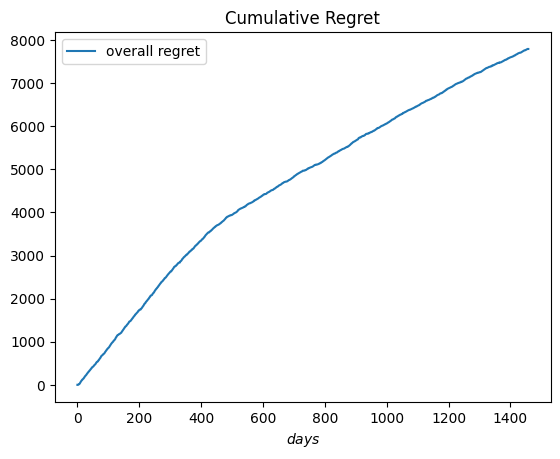

In [22]:
clairprofit = np.array(clairvoyant_profits)
bidagentprofit = np.array(bidding_agent_profits)
print(clairprofit.shape)
print(bidagentprofit.shape)

cumulative_regret = np.cumsum(clairprofit[1:]-bidagentprofit)

plt.figure()
plt.plot(cumulative_regret, label="overall regret")
# plt.plot(clairprofit[1:], label="Clairvoyant utility")
# plt.plot(bidagentprofit, label="Bidding agent utility")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$days$')
plt.show();


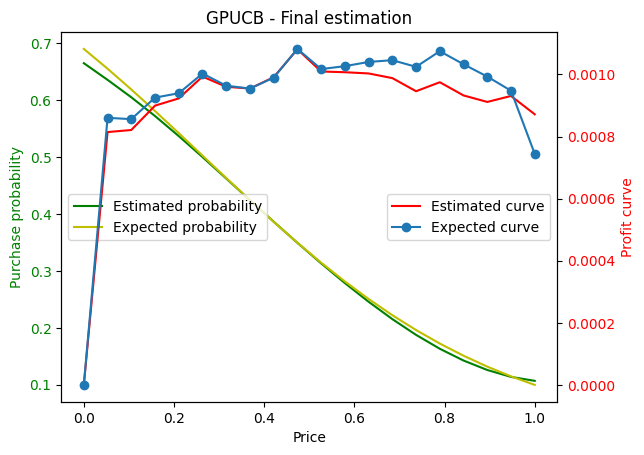

In [16]:
estimated_purchase_probability = (pricing_agent.mu_t + pricing_agent.beta(pricing_agent.t) * pricing_agent.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent.arms - pricing_agent.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent.arms - pricing_agent.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent.average_customer_percentages*(conversion_probabilities*pricing_agent.arms - pricing_agent.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

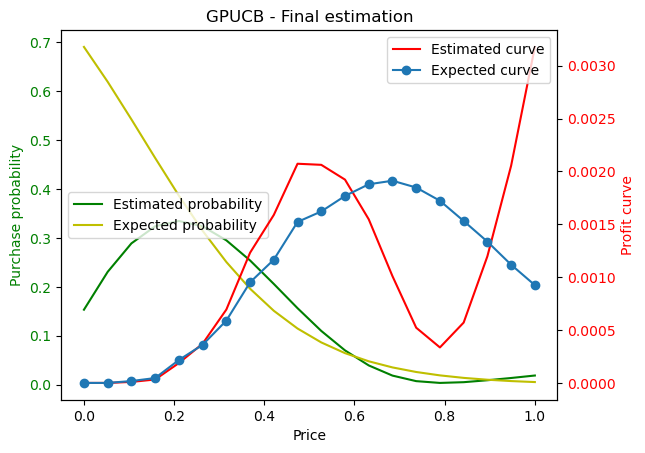

In [ ]:
estimated_purchase_probability = (pricing_agent.mu_t + pricing_agent.beta(pricing_agent.t) * pricing_agent.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * (pricing_agent.arms - pricing_agent.average_bidding_costs)
ucbs = estimated_profits_per_customer * pricing_agent.average_customer_percentages

prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)

fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent.arms - pricing_agent.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, conversion_probabilities*(pricing_agent.arms - pricing_agent.average_bidding_costs)*pricing_agent.average_customer_percentages, 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='upper right')

plt.title('GPUCB - Final estimation')
plt.show()

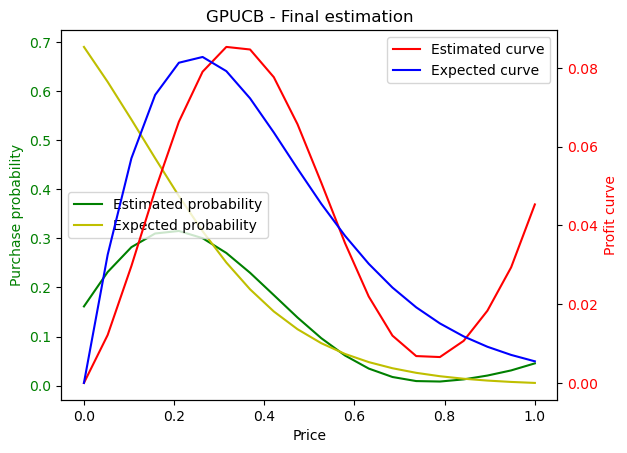

In [ ]:
estimated_purchase_probability = (pricing_agent.mu_t + pricing_agent.beta(pricing_agent.t) * pricing_agent.sigma_t)
ucbs = estimated_purchase_probability * (pricing_agent.arms - pricing_agent.average_bidding_costs)

prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)

fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, conversion_probabilities*prices, 'b-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='upper right')

plt.title('GPUCB - Final estimation')
plt.show()

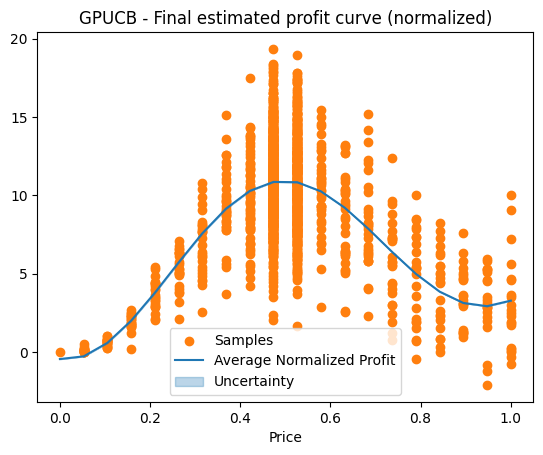

In [17]:
price_hist = pricing_agent.action_hist
profits = pricing_agent.reward_hist

gp = RBFGaussianProcess(scale=scale)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
# plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

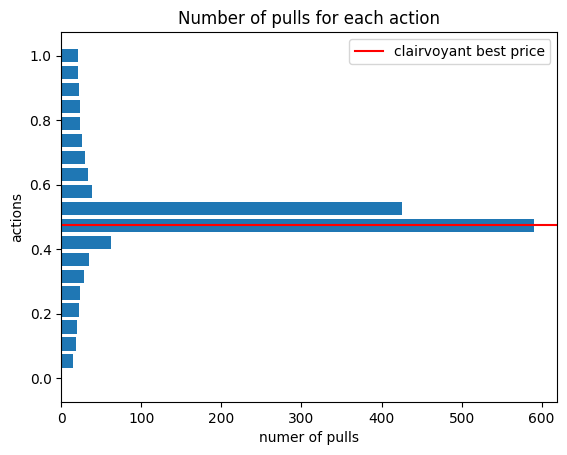

In [31]:
plt.figure()
plt.barh(prices, pricing_agent.N_pulls, height = (prices[1] - prices[0])*0.8)
plt.axhline(y=best_price, color = 'r', linestyle = '-', label = 'clairvoyant best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.title('Number of pulls for each action')
plt.legend()
plt.show();

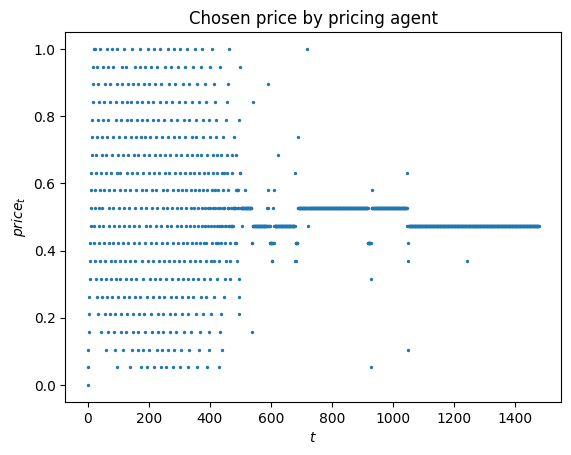

In [19]:
price_hist = pricing_agent.action_hist

plt.figure()
plt.scatter(np.arange(len(price_hist)), price_hist, s=2, label='Chosen price')
plt.xlabel('$t$')
plt.ylabel('$price_t$')
plt.title('Chosen price by pricing agent')
# plt.legend()
plt.show()

In [23]:
chosen_price, purchase_probability_t, average_bid_cost_t = pricing_agent.pull_arm()
print(chosen_price)
print(purchase_probability_t)
print(average_bid_cost_t)
print(best_price)

0.47368421052631576
0.34941958663435396
0.0782352633120071
0.47368421052631576


In [ ]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

np.random.seed(2)

# product
min_price, max_price = 10, 20
production_cost = 10
price_discretization = 8
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(production_cost, min_price, max_price)  # equals to scaled_min_price

# Pricing Environment and Agent
# Logistic model example
model='logistic'
alpha=0.8
beta=-3
scale=2
TotalDays = 365
pricing_env = StochasticPricingEnvironment(model, alpha, beta)
pricing_agent_2 = GPUCBAgent(TotalDays, scaled_min_price, scaled_max_price, discretization=price_discretization, scale=scale)
n_customers_t = 0        # to be determined every day after bidding
# for clairvoyant's use
prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)


# Bidding Environment parameters
n_users = 10000
n_competitors = 2
ctrs = np.ones(n_competitors+1)
B = 100
auction = SecondPriceAuction(ctrs)
bidding_agent_profits = []
clairvoyant_profits = []

# Foreach day
for day in range(price_discretization*4):
    # pricing agent sets the price of the day
    p_t, purchase_probability_t, average_bid_cost_t = pricing_agent_2.pull_arm()

    # Bidding Environment
    bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

    # Bidding Agents
    my_valuation_t = p_t*purchase_probability_t # equals to daily_set_price (which took into account the production cost)

    # Exploratory round to estimate the purchase probability of each price
    if(day == 0):
        my_valuation_t = scaled_max_price


    eta = 1/np.sqrt(n_users) # from theory
    agentMP = MultiplicativePacingAgent(valuation=my_valuation_t,
                                    budget=B,
                                    T=n_users,
                                    eta=eta)
    # agentCURMP = ContinuousUpdatedRhoMPAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    # agentUCB = UCBAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF = UCBNFAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF1 = UCBNFAgent(my_valuation_t, B, n_users, range=0.1)    # range works as the hyperparameter in this problem

    bidding_agents = {
        "Multiplicative Pacing": agentMP,
        # "Continuously updated Rho MP": agentCURMP,
        # "Plain UCB": agentUCB,
        # "UCB with negative feedback": agentNF,
        # "UCBNF with range 0.1" : agentNF1
    }

    utilities = np.zeros((len(bidding_agents), n_users))
    my_bids = np.zeros((len(bidding_agents), n_users))
    my_payments = np.zeros((len(bidding_agents), n_users))
    total_wins = np.zeros((len(bidding_agents)))
    bidding_agent_profit=0
    number_sale_t=0

    np.random.seed(day)
    for u in range(n_users):
        # bidding process
        for idx, (name, agent) in enumerate(bidding_agents.items()):
            my_bid = agent.bid()
            winners, m_t = bidding_env.round(u, my_bid)
            my_win = int(winners==n_competitors)
            f_t, c_t = (my_valuation_t-m_t)*my_win, m_t*my_win
            agent.update(f_t, c_t)
            utilities[idx,u] = f_t
            my_bids[idx,u] = my_bid
            my_payments[idx,u] = c_t
            total_wins[idx] += my_win
    if(total_wins[0] != 0):
        n_customers_t = total_wins[0]
        scaled_payed_bid_per_user = np.sum(my_payments[0,:]) / total_wins[0]


    # Update pricing agent
    # Exploratory round to estimate purchase probability
    if(day == 0):
        original_a_t = pricing_agent_2.a_t
        customers_per_price = int(n_customers_t / price_discretization)
        for idx, price in enumerate(pricing_agent_2.arms):
            sales_per_price = pricing_env.round(price, customers_per_price)
            pricing_agent_2.a_t = idx
            pricing_agent_2.update(sales_per_price, customers_per_price)
            # print(f'Price # {idx} : {price} with {sales_per_price}/{customers_per_price} sales')
        pricing_agent_2.a_t = original_a_t
    # Normal rounds
    else:
        number_sale_t = pricing_env.round(p_t, n_customers_t)
        pricing_agent_2.update(number_sale_t, n_customers_t, scaled_payed_bid_per_user, n_customers_t/n_users)
        bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
        bidding_agent_profits.append(bidding_agent_profit)



At day 0 :	price_t = 0.0000, with estimated purchase probability = 1.0000          
		my valuation = 1.0000, won 349/10000 auctions, with a mean bid of 0.2842           
		we sold 0/349 (0.00%) products, for a total net profit of 0.0000          
		clairvoyant sale : 0/1 (0.00%), for a total net profit of 0.0000

At day 1 :	price_t = 1.0000, with estimated purchase probability = 0.1752          
		my valuation = 0.1752, won 141/10000 auctions, with a mean bid of 0.0852           
		we sold 13/141 (9.22%) products, for a total net profit of 0.9844          
		clairvoyant sale : 9/95 (9.47%), for a total net profit of 2.4703

At day 2 :	price_t = 0.5714, with estimated purchase probability = 0.3055          
		my valuation = 0.1746, won 150/10000 auctions, with a mean bid of 0.0804           
		we sold 35/150 (23.33%) products, for a total net profit of 7.9461          
		clairvoyant sale : 80/283 (28.27%), for a total net profit of 14.9471

At day 3 :	price_t = 0.4286, with estimated pu

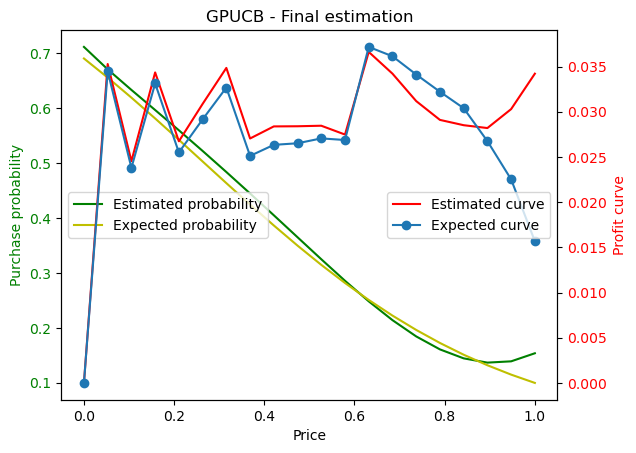

In [ ]:
# 40 rounds

estimated_purchase_probability = (pricing_agent_2.mu_t + pricing_agent_2.beta(pricing_agent_2.t) * pricing_agent_2.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent_2.arms - pricing_agent_2.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent_2.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent_2.arms - pricing_agent_2.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent_2.average_customer_percentages*(conversion_probabilities*pricing_agent_2.arms - pricing_agent_2.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

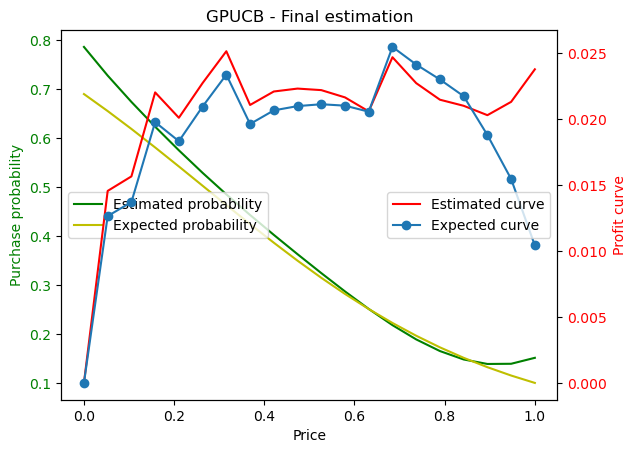

In [ ]:
# 60 rounds

estimated_purchase_probability = (pricing_agent_2.mu_t + pricing_agent_2.beta(pricing_agent_2.t) * pricing_agent_2.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent_2.arms - pricing_agent_2.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent_2.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent_2.arms - pricing_agent_2.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent_2.average_customer_percentages*(conversion_probabilities*pricing_agent_2.arms - pricing_agent_2.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

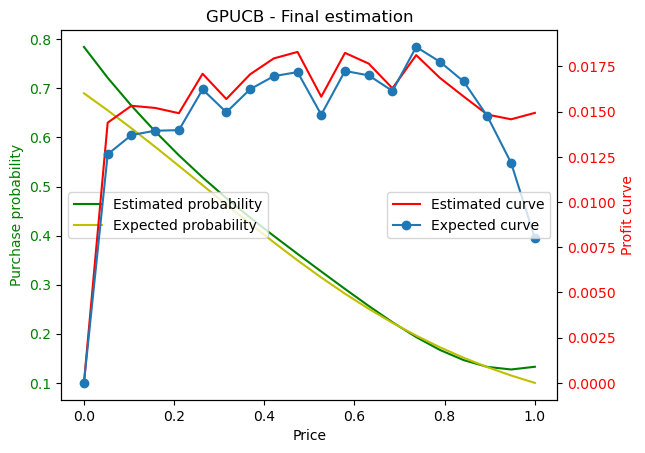

In [ ]:
# 80 rounds

estimated_purchase_probability = (pricing_agent_2.mu_t + pricing_agent_2.beta(pricing_agent_2.t) * pricing_agent_2.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent_2.arms - pricing_agent_2.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent_2.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent_2.arms - pricing_agent_2.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent_2.average_customer_percentages*(conversion_probabilities*pricing_agent_2.arms - pricing_agent_2.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

### 365*6 rounds - Multiplicative Pacing bidder

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

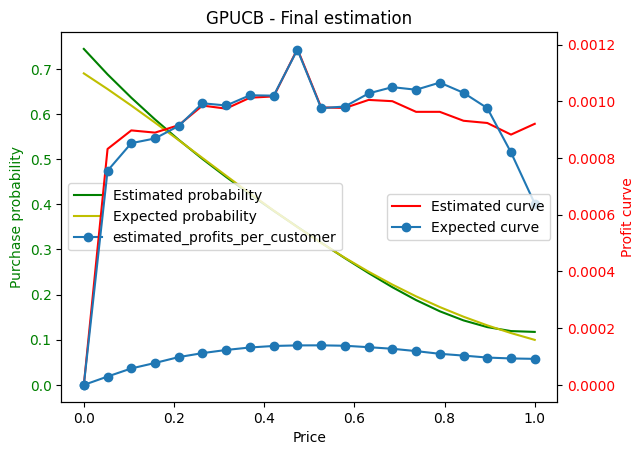

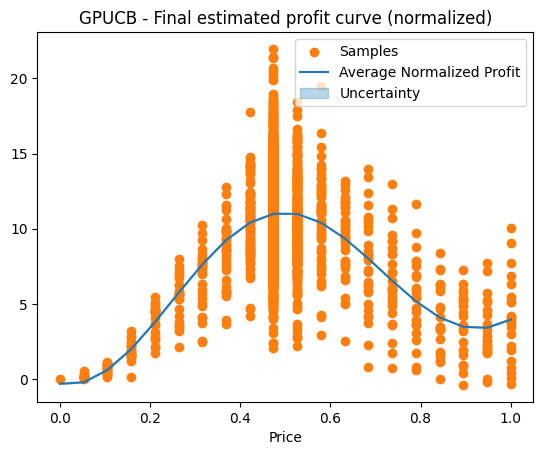

NameError: name 'pricing_agent3' is not defined

<Figure size 640x480 with 0 Axes>

In [13]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

np.random.seed(2)

# product
min_price, max_price = 10, 20
production_cost = 10
price_discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(production_cost, min_price, max_price)  # equals to scaled_min_price

# Pricing Environment and Agent
# Logistic model example
model='logistic'
alpha=0.8
beta=-3
scale=2
TotalDays = 365 * 6
pricing_env = StochasticPricingEnvironment(model, alpha, beta)
pricing_agent_3 = GPUCBAgent(TotalDays, scaled_min_price, scaled_max_price, discretization=price_discretization, scale=scale)
n_customers_t = 0        # to be determined every day after bidding
# for clairvoyant's use
prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)


# Bidding Environment parameters
n_users = 10000
n_competitors = 2
ctrs = np.ones(n_competitors+1)
B = 100
auction = SecondPriceAuction(ctrs)
bidding_agent_profits = []
clairvoyant_profits = []

# Foreach day
for day in range(TotalDays):
    # pricing agent sets the price of the day
    p_t, purchase_probability_t, average_bid_cost_t = pricing_agent_3.pull_arm()

    # Bidding Environment
    bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

    # Bidding Agents
    my_valuation_t = p_t*purchase_probability_t # equals to daily_set_price (which took into account the production cost)

    # Exploratory round to estimate the purchase probability of each price
    if(day == 0):
        my_valuation_t = scaled_max_price


    eta = 1/np.sqrt(n_users) # from theory
    agentMP = MultiplicativePacingAgent(valuation=my_valuation_t,
                                    budget=B,
                                    T=n_users,
                                    eta=eta)
    # agentCURMP = ContinuousUpdatedRhoMPAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    # agentUCB = UCBAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF = UCBNFAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF1 = UCBNFAgent(my_valuation_t, B, n_users, range=0.1)    # range works as the hyperparameter in this problem

    bidding_agents = {
        "Multiplicative Pacing": agentMP,
        # "Continuously updated Rho MP": agentCURMP,
        # "Plain UCB": agentUCB,
        # "UCB with negative feedback": agentNF,
        # "UCBNF with range 0.1" : agentNF1
    }

    utilities = np.zeros((len(bidding_agents), n_users))
    my_bids = np.zeros((len(bidding_agents), n_users))
    my_payments = np.zeros((len(bidding_agents), n_users))
    total_wins = np.zeros((len(bidding_agents)))
    bidding_agent_profit=0
    number_sale_t=0

    np.random.seed(day)
    for u in range(n_users):
        # bidding process
        for idx, (name, agent) in enumerate(bidding_agents.items()):
            my_bid = agent.bid()
            winners, m_t = bidding_env.round(u, my_bid)
            my_win = int(winners==n_competitors)
            f_t, c_t = (my_valuation_t-m_t)*my_win, m_t*my_win
            agent.update(f_t, c_t)
            utilities[idx,u] = f_t
            my_bids[idx,u] = my_bid
            my_payments[idx,u] = c_t
            total_wins[idx] += my_win
    if(total_wins[0] != 0):
        n_customers_t = total_wins[0]
        scaled_payed_bid_per_user = np.sum(my_payments[0,:]) / total_wins[0]


    # Update pricing agent
    # Exploratory round to estimate purchase probability
    if(day == 0):
        original_a_t = pricing_agent_3.a_t
        customers_per_price = int(n_customers_t / price_discretization)
        for idx, price in enumerate(pricing_agent_3.arms):
            sales_per_price = pricing_env.round(price, customers_per_price)
            pricing_agent_3.a_t = idx
            pricing_agent_3.update(sales_per_price, customers_per_price)
            # print(f'Price # {idx} : {price} with {sales_per_price}/{customers_per_price} sales')
        pricing_agent_3.a_t = original_a_t
    # Normal rounds
    else:
        number_sale_t = pricing_env.round(p_t, n_customers_t)
        pricing_agent_3.update(number_sale_t, n_customers_t, scaled_payed_bid_per_user, n_customers_t/n_users)
        bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
        bidding_agent_profits.append(bidding_agent_profit)

    print(day)


# Clairvoyant utility computation

# exploit pricing agent's history to compute best price
price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist
cgp = RBFGaussianProcess(scale=scale).fit(price_hist, profits)
mu, sigma = cgp.predict(prices)
best_price_idx = np.argmax(mu+sigma)
best_price = prices[best_price_idx]
clairvoyant_valuation = best_price * conversion_probabilities[best_price_idx]

clairvoyant_profits = []
for day in range(TotalDays):
  bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

  clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, clairvoyant_valuation)
  clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
  clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[best_price_idx])
  clairvoyant_profit = clairvoyant_sales*best_price - np.sum(clairvoyant_payments)

  clairvoyant_profits.append(clairvoyant_profit)



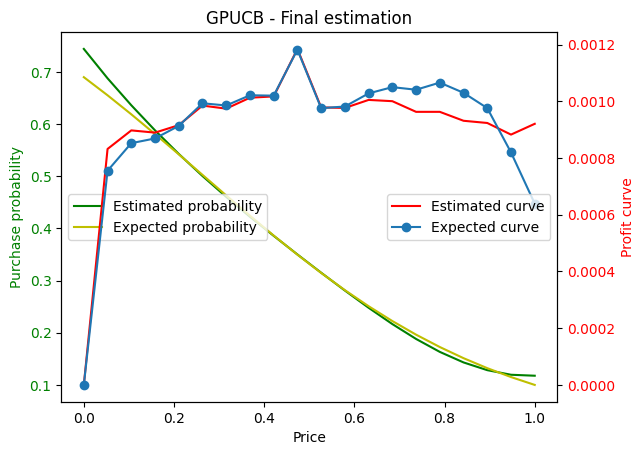

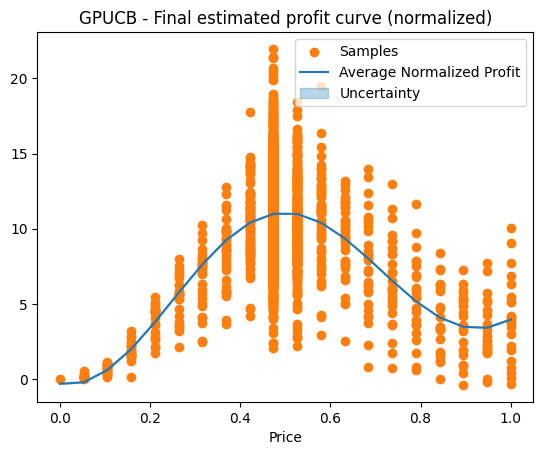

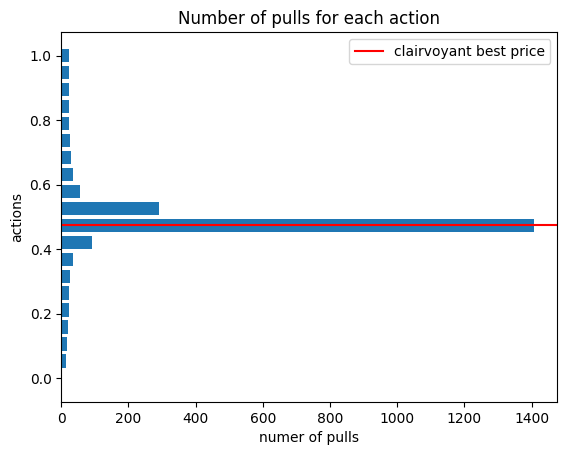

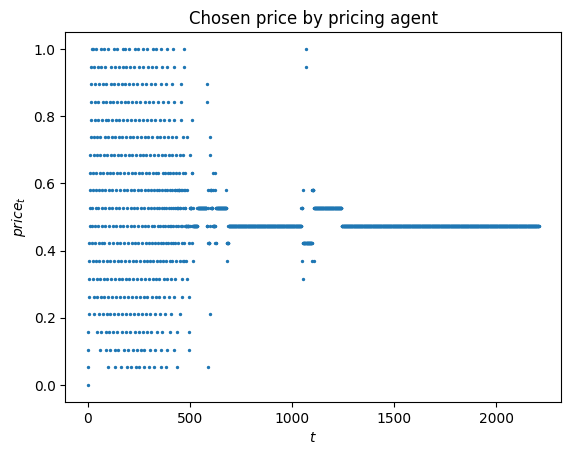

(2190,)
(2189,)


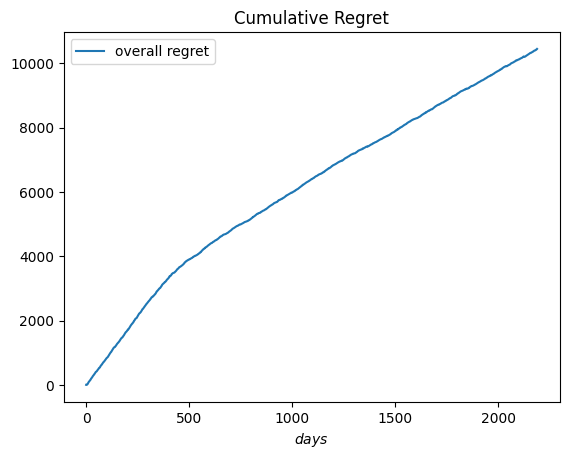

In [15]:

estimated_purchase_probability = (pricing_agent_3.mu_t + pricing_agent_3.beta(pricing_agent_3.t) * pricing_agent_3.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent_3.arms - pricing_agent_3.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent_3.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
# ax1.plot(prices, estimated_profits_per_customer, 'o-', label='estimated_profits_per_customer')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent_3.arms - pricing_agent_3.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent_3.average_customer_percentages*(conversion_probabilities*pricing_agent_3.arms - pricing_agent_3.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist

gp = RBFGaussianProcess(scale=scale)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
# plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();


plt.figure()
plt.barh(prices, pricing_agent_3.N_pulls, height = (prices[1] - prices[0])*0.8)
plt.axhline(y=best_price, color = 'r', linestyle = '-', label = 'clairvoyant best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.title('Number of pulls for each action')
plt.legend()
plt.show();



price_hist = pricing_agent_3.action_hist

plt.figure()
plt.scatter(np.arange(len(price_hist)), price_hist, s=2, label='Chosen price')
plt.xlabel('$t$')
plt.ylabel('$price_t$')
plt.title('Chosen price by pricing agent')
# plt.legend()
plt.show()


clairprofit = np.array(clairvoyant_profits)
bidagentprofit = np.array(bidding_agent_profits)
print(clairprofit.shape)
print(bidagentprofit.shape)

cumulative_regret = np.cumsum(clairprofit[1:]-bidagentprofit)

plt.figure()
plt.plot(cumulative_regret, label="overall regret")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$days$')
plt.show();


### 365*6 rounds - Continuously Updated Rho Multiplicative Pacing bidder

In [14]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

np.random.seed(2)

# product
min_price, max_price = 10, 20
production_cost = 10
price_discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(production_cost, min_price, max_price)  # equals to scaled_min_price

# Pricing Environment and Agent
# Logistic model example
model='logistic'
alpha=0.8
beta=-3
scale=2
TotalDays = 365 * 6
pricing_env = StochasticPricingEnvironment(model, alpha, beta)
pricing_agent_3 = GPUCBAgent(TotalDays, scaled_min_price, scaled_max_price, discretization=price_discretization, scale=scale)
n_customers_t = 0        # to be determined every day after bidding
# for clairvoyant's use
prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)


# Bidding Environment parameters
n_users = 10000
n_competitors = 2
ctrs = np.ones(n_competitors+1)
B = 100
auction = SecondPriceAuction(ctrs)
bidding_agent_profits = []
clairvoyant_profits = []

# Foreach day
for day in range(TotalDays):
    # pricing agent sets the price of the day
    p_t, purchase_probability_t, average_bid_cost_t = pricing_agent_3.pull_arm()

    # Bidding Environment
    bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

    # Bidding Agents
    my_valuation_t = p_t*purchase_probability_t # equals to daily_set_price (which took into account the production cost)

    # Exploratory round to estimate the purchase probability of each price
    if(day == 0):
        my_valuation_t = scaled_max_price


    eta = 1/np.sqrt(n_users) # from theory
    # agentMP = MultiplicativePacingAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    agentCURMP = ContinuousUpdatedRhoMPAgent(valuation=my_valuation_t,
                                    budget=B,
                                    T=n_users,
                                    eta=eta)
    # agentUCB = UCBAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF = UCBNFAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF1 = UCBNFAgent(my_valuation_t, B, n_users, range=0.1)    # range works as the hyperparameter in this problem

    bidding_agents = {
        # "Multiplicative Pacing": agentMP,
        "Continuously updated Rho MP": agentCURMP,
        # "Plain UCB": agentUCB,
        # "UCB with negative feedback": agentNF,
        # "UCBNF with range 0.1" : agentNF1
    }

    utilities = np.zeros((len(bidding_agents), n_users))
    my_bids = np.zeros((len(bidding_agents), n_users))
    my_payments = np.zeros((len(bidding_agents), n_users))
    total_wins = np.zeros((len(bidding_agents)))
    bidding_agent_profit=0
    number_sale_t=0

    np.random.seed(day)
    for u in range(n_users):
        # bidding process
        for idx, (name, agent) in enumerate(bidding_agents.items()):
            my_bid = agent.bid()
            winners, m_t = bidding_env.round(u, my_bid)
            my_win = int(winners==n_competitors)
            f_t, c_t = (my_valuation_t-m_t)*my_win, m_t*my_win
            agent.update(f_t, c_t)
            utilities[idx,u] = f_t
            my_bids[idx,u] = my_bid
            my_payments[idx,u] = c_t
            total_wins[idx] += my_win
    if(total_wins[0] != 0):
        n_customers_t = total_wins[0]
        scaled_payed_bid_per_user = np.sum(my_payments[0,:]) / total_wins[0]


    # Update pricing agent
    # Exploratory round to estimate purchase probability
    if(day == 0):
        original_a_t = pricing_agent_3.a_t
        customers_per_price = int(n_customers_t / price_discretization)
        for idx, price in enumerate(pricing_agent_3.arms):
            sales_per_price = pricing_env.round(price, customers_per_price)
            pricing_agent_3.a_t = idx
            pricing_agent_3.update(sales_per_price, customers_per_price)
            # print(f'Price # {idx} : {price} with {sales_per_price}/{customers_per_price} sales')
        pricing_agent_3.a_t = original_a_t
    # Normal rounds
    else:
        number_sale_t = pricing_env.round(p_t, n_customers_t)
        pricing_agent_3.update(number_sale_t, n_customers_t, scaled_payed_bid_per_user, n_customers_t/n_users)
        bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
        bidding_agent_profits.append(bidding_agent_profit)

    print(day)


# Clairvoyant utility computation

# exploit pricing agent's history to compute best price
price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist
cgp = RBFGaussianProcess(scale=scale).fit(price_hist, profits)
mu, sigma = cgp.predict(prices)
best_price_idx = np.argmax(mu+sigma)
best_price = prices[best_price_idx]
clairvoyant_valuation = best_price * conversion_probabilities[best_price_idx]

clairvoyant_profits = []
for day in range(TotalDays):
  bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

  clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, clairvoyant_valuation)
  clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
  clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[best_price_idx])
  clairvoyant_profit = clairvoyant_sales*best_price - np.sum(clairvoyant_payments)

  clairvoyant_profits.append(clairvoyant_profit)



<ipython-input-11-9162a74f1a5b>:21: RuntimeWarning: divide by zero encountered in scalar divide
  self.rho = self.budget/(self.T-self.t)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

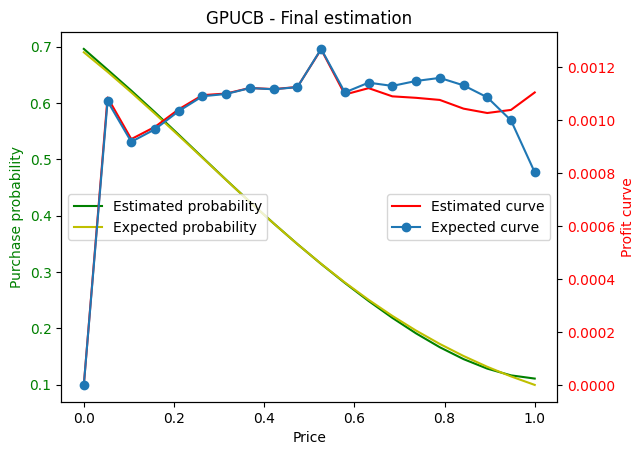

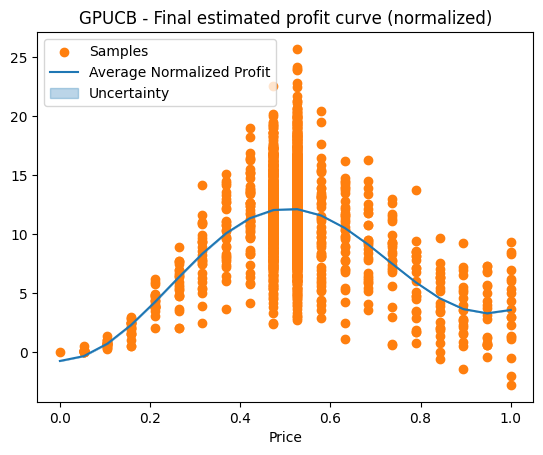

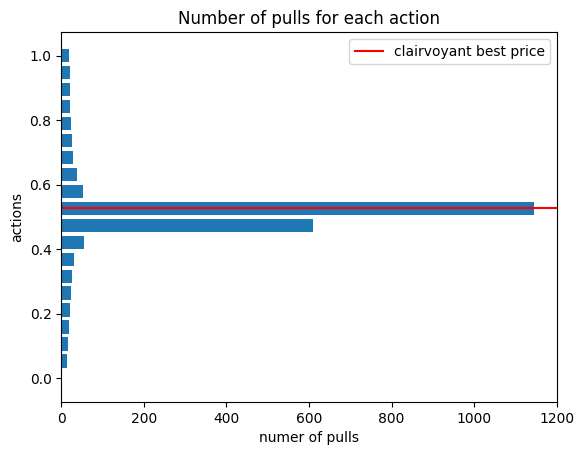

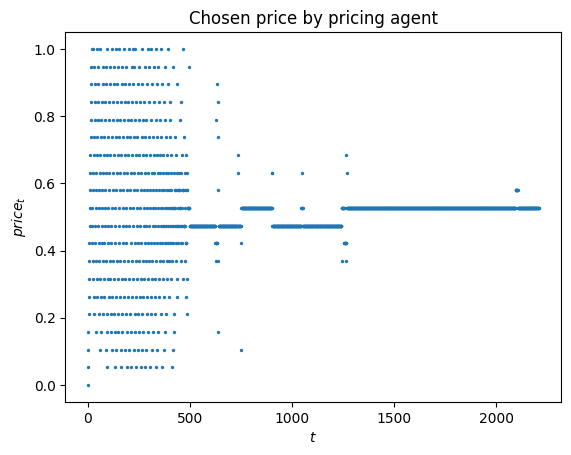

(2190,)
(2189,)


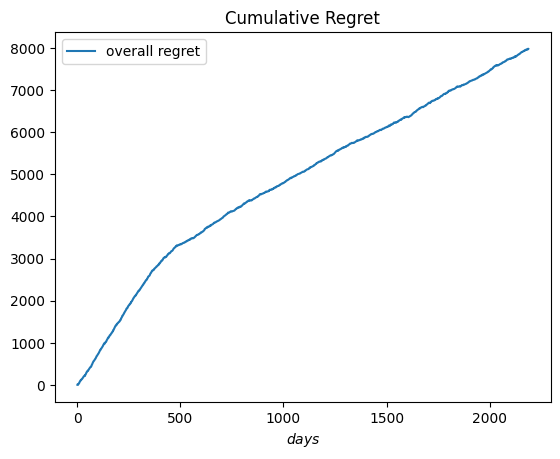

In [15]:

estimated_purchase_probability = (pricing_agent_3.mu_t + pricing_agent_3.beta(pricing_agent_3.t) * pricing_agent_3.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent_3.arms - pricing_agent_3.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent_3.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
# ax1.plot(prices, estimated_profits_per_customer, 'o-', label='estimated_profits_per_customer')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent_3.arms - pricing_agent_3.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent_3.average_customer_percentages*(conversion_probabilities*pricing_agent_3.arms - pricing_agent_3.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist

gp = RBFGaussianProcess(scale=scale)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
# plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();


plt.figure()
plt.barh(prices, pricing_agent_3.N_pulls, height = (prices[1] - prices[0])*0.8)
plt.axhline(y=best_price, color = 'r', linestyle = '-', label = 'clairvoyant best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.title('Number of pulls for each action')
plt.legend()
plt.show();



price_hist = pricing_agent_3.action_hist

plt.figure()
plt.scatter(np.arange(len(price_hist)), price_hist, s=2, label='Chosen price')
plt.xlabel('$t$')
plt.ylabel('$price_t$')
plt.title('Chosen price by pricing agent')
# plt.legend()
plt.show()


clairprofit = np.array(clairvoyant_profits)
bidagentprofit = np.array(bidding_agent_profits)
print(clairprofit.shape)
print(bidagentprofit.shape)

cumulative_regret = np.cumsum(clairprofit[1:]-bidagentprofit)

plt.figure()
plt.plot(cumulative_regret, label="overall regret")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$days$')
plt.show();


### 365*6 rounds - Plain UCB bidder

In [16]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

np.random.seed(2)

# product
min_price, max_price = 10, 20
production_cost = 10
price_discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(production_cost, min_price, max_price)  # equals to scaled_min_price

# Pricing Environment and Agent
# Logistic model example
model='logistic'
alpha=0.8
beta=-3
scale=2
TotalDays = 365 * 6
pricing_env = StochasticPricingEnvironment(model, alpha, beta)
pricing_agent_3 = GPUCBAgent(TotalDays, scaled_min_price, scaled_max_price, discretization=price_discretization, scale=scale)
n_customers_t = 0        # to be determined every day after bidding
# for clairvoyant's use
prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)


# Bidding Environment parameters
n_users = 10000
n_competitors = 2
ctrs = np.ones(n_competitors+1)
B = 100
auction = SecondPriceAuction(ctrs)
bidding_agent_profits = []
clairvoyant_profits = []

# Foreach day
for day in range(TotalDays):
    # pricing agent sets the price of the day
    p_t, purchase_probability_t, average_bid_cost_t = pricing_agent_3.pull_arm()

    # Bidding Environment
    bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

    # Bidding Agents
    my_valuation_t = p_t*purchase_probability_t # equals to daily_set_price (which took into account the production cost)

    # Exploratory round to estimate the purchase probability of each price
    if(day == 0):
        my_valuation_t = scaled_max_price


    eta = 1/np.sqrt(n_users) # from theory
    # agentMP = MultiplicativePacingAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    # agentCURMP = ContinuousUpdatedRhoMPAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    agentUCB = UCBAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF = UCBNFAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF1 = UCBNFAgent(my_valuation_t, B, n_users, range=0.1)    # range works as the hyperparameter in this problem

    bidding_agents = {
        # "Multiplicative Pacing": agentMP,
        # "Continuously updated Rho MP": agentCURMP,
        "Plain UCB": agentUCB,
        # "UCB with negative feedback": agentNF,
        # "UCBNF with range 0.1" : agentNF1
    }

    utilities = np.zeros((len(bidding_agents), n_users))
    my_bids = np.zeros((len(bidding_agents), n_users))
    my_payments = np.zeros((len(bidding_agents), n_users))
    total_wins = np.zeros((len(bidding_agents)))
    bidding_agent_profit=0
    number_sale_t=0

    np.random.seed(day)
    for u in range(n_users):
        # bidding process
        for idx, (name, agent) in enumerate(bidding_agents.items()):
            my_bid = agent.bid()
            winners, m_t = bidding_env.round(u, my_bid)
            my_win = int(winners==n_competitors)
            f_t, c_t = (my_valuation_t-m_t)*my_win, m_t*my_win
            agent.update(f_t, c_t)
            utilities[idx,u] = f_t
            my_bids[idx,u] = my_bid
            my_payments[idx,u] = c_t
            total_wins[idx] += my_win
    if(total_wins[0] != 0):
        n_customers_t = total_wins[0]
        scaled_payed_bid_per_user = np.sum(my_payments[0,:]) / total_wins[0]


    # Update pricing agent
    # Exploratory round to estimate purchase probability
    if(day == 0):
        original_a_t = pricing_agent_3.a_t
        customers_per_price = int(n_customers_t / price_discretization)
        for idx, price in enumerate(pricing_agent_3.arms):
            sales_per_price = pricing_env.round(price, customers_per_price)
            pricing_agent_3.a_t = idx
            pricing_agent_3.update(sales_per_price, customers_per_price)
            # print(f'Price # {idx} : {price} with {sales_per_price}/{customers_per_price} sales')
        pricing_agent_3.a_t = original_a_t
    # Normal rounds
    else:
        number_sale_t = pricing_env.round(p_t, n_customers_t)
        pricing_agent_3.update(number_sale_t, n_customers_t, scaled_payed_bid_per_user, n_customers_t/n_users)
        bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
        bidding_agent_profits.append(bidding_agent_profit)

    print(day)


# Clairvoyant utility computation

# exploit pricing agent's history to compute best price
price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist
cgp = RBFGaussianProcess(scale=scale).fit(price_hist, profits)
mu, sigma = cgp.predict(prices)
best_price_idx = np.argmax(mu+sigma)
best_price = prices[best_price_idx]
clairvoyant_valuation = best_price * conversion_probabilities[best_price_idx]

clairvoyant_profits = []
for day in range(TotalDays):
  bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

  clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, clairvoyant_valuation)
  clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
  clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[best_price_idx])
  clairvoyant_profit = clairvoyant_sales*best_price - np.sum(clairvoyant_payments)

  clairvoyant_profits.append(clairvoyant_profit)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

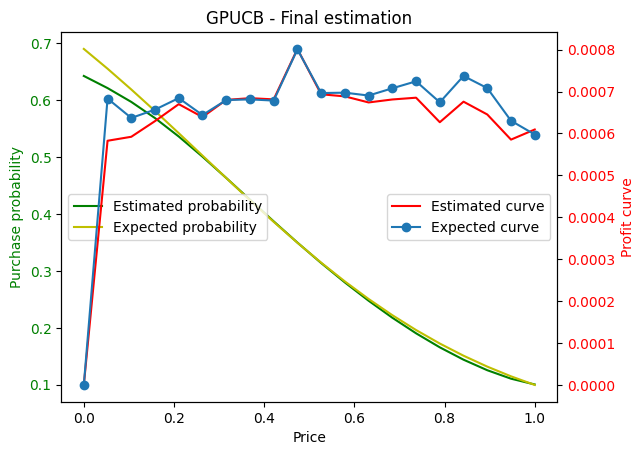

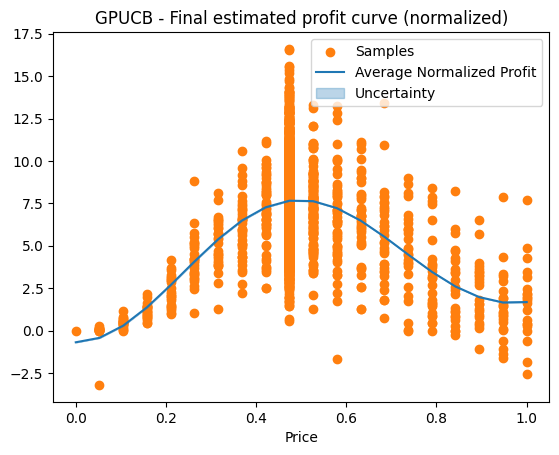

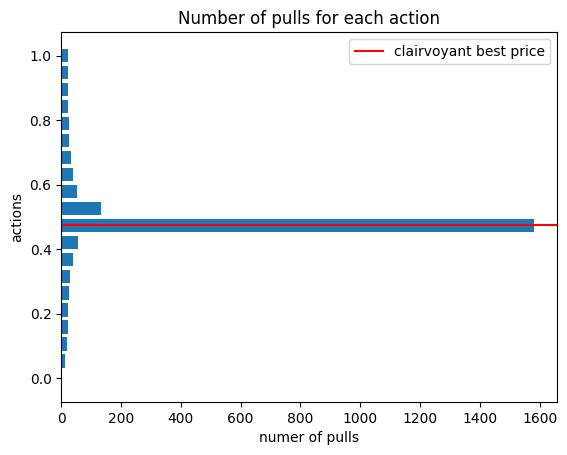

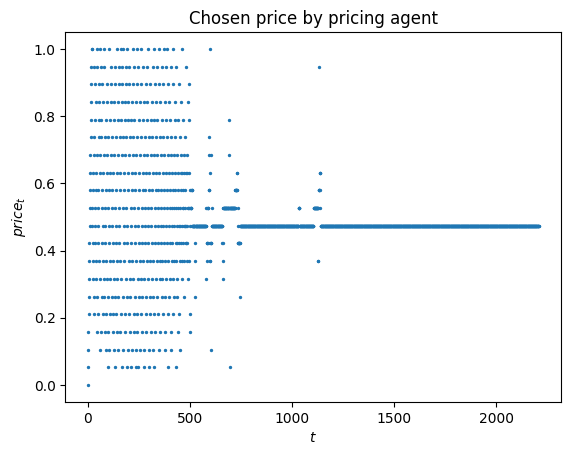

(2190,)
(2189,)


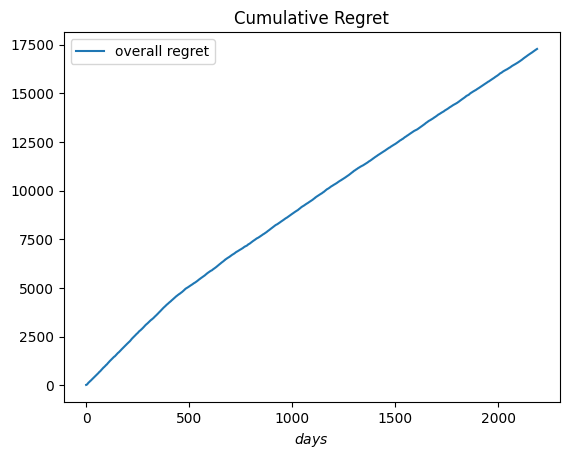

In [17]:

estimated_purchase_probability = (pricing_agent_3.mu_t + pricing_agent_3.beta(pricing_agent_3.t) * pricing_agent_3.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent_3.arms - pricing_agent_3.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent_3.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
# ax1.plot(prices, estimated_profits_per_customer, 'o-', label='estimated_profits_per_customer')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent_3.arms - pricing_agent_3.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent_3.average_customer_percentages*(conversion_probabilities*pricing_agent_3.arms - pricing_agent_3.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist

gp = RBFGaussianProcess(scale=scale)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
# plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();


plt.figure()
plt.barh(prices, pricing_agent_3.N_pulls, height = (prices[1] - prices[0])*0.8)
plt.axhline(y=best_price, color = 'r', linestyle = '-', label = 'clairvoyant best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.title('Number of pulls for each action')
plt.legend()
plt.show();



price_hist = pricing_agent_3.action_hist

plt.figure()
plt.scatter(np.arange(len(price_hist)), price_hist, s=2, label='Chosen price')
plt.xlabel('$t$')
plt.ylabel('$price_t$')
plt.title('Chosen price by pricing agent')
# plt.legend()
plt.show()


clairprofit = np.array(clairvoyant_profits)
bidagentprofit = np.array(bidding_agent_profits)
print(clairprofit.shape)
print(bidagentprofit.shape)

cumulative_regret = np.cumsum(clairprofit[1:]-bidagentprofit)

plt.figure()
plt.plot(cumulative_regret, label="overall regret")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$days$')
plt.show();


### 365*6 rounds - UCB with Negative Feedback bidder

In [22]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

np.random.seed(2)

# product
min_price, max_price = 10, 20
production_cost = 10
price_discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(production_cost, min_price, max_price)  # equals to scaled_min_price

# Pricing Environment and Agent
# Logistic model example
model='logistic'
alpha=0.8
beta=-3
scale=2
TotalDays = 365 * 6
pricing_env = StochasticPricingEnvironment(model, alpha, beta)
pricing_agent_3 = GPUCBAgent(TotalDays, scaled_min_price, scaled_max_price, discretization=price_discretization, scale=scale)
n_customers_t = 0        # to be determined every day after bidding
# for clairvoyant's use
prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)


# Bidding Environment parameters
n_users = 10000
n_competitors = 2
ctrs = np.ones(n_competitors+1)
B = 100
auction = SecondPriceAuction(ctrs)
bidding_agent_profits = []
clairvoyant_profits = []

# Foreach day
for day in range(TotalDays):
    # pricing agent sets the price of the day
    p_t, purchase_probability_t, average_bid_cost_t = pricing_agent_3.pull_arm()

    # Bidding Environment
    bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

    # Bidding Agents
    my_valuation_t = p_t*purchase_probability_t # equals to daily_set_price (which took into account the production cost)

    # Exploratory round to estimate the purchase probability of each price
    if(day == 0):
        my_valuation_t = scaled_max_price


    eta = 1/np.sqrt(n_users) # from theory
    # agentMP = MultiplicativePacingAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    # agentCURMP = ContinuousUpdatedRhoMPAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    # agentUCB = UCBAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    agentNF = UCBNFAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF1 = UCBNFAgent(my_valuation_t, B, n_users, range=0.1)    # range works as the hyperparameter in this problem

    bidding_agents = {
        # "Multiplicative Pacing": agentMP,
        # "Continuously updated Rho MP": agentCURMP,
        # "Plain UCB": agentUCB,
        "UCB with negative feedback": agentNF,
        # "UCBNF with range 0.1" : agentNF1
    }

    utilities = np.zeros((len(bidding_agents), n_users))
    my_bids = np.zeros((len(bidding_agents), n_users))
    my_payments = np.zeros((len(bidding_agents), n_users))
    total_wins = np.zeros((len(bidding_agents)))
    bidding_agent_profit=0
    number_sale_t=0

    np.random.seed(day)
    for u in range(n_users):
        # bidding process
        for idx, (name, agent) in enumerate(bidding_agents.items()):
            my_bid = agent.bid()
            winners, m_t = bidding_env.round(u, my_bid)
            my_win = int(winners==n_competitors)
            f_t, c_t = (my_valuation_t-m_t)*my_win, m_t*my_win
            agent.update(f_t, c_t)
            utilities[idx,u] = f_t
            my_bids[idx,u] = my_bid
            my_payments[idx,u] = c_t
            total_wins[idx] += my_win
    if(total_wins[0] != 0):
        n_customers_t = total_wins[0]
        scaled_payed_bid_per_user = np.sum(my_payments[0,:]) / total_wins[0]


    # Update pricing agent
    # Exploratory round to estimate purchase probability
    if(day == 0):
        original_a_t = pricing_agent_3.a_t
        customers_per_price = int(n_customers_t / price_discretization)
        for idx, price in enumerate(pricing_agent_3.arms):
            sales_per_price = pricing_env.round(price, customers_per_price)
            pricing_agent_3.a_t = idx
            pricing_agent_3.update(sales_per_price, customers_per_price)
            # print(f'Price # {idx} : {price} with {sales_per_price}/{customers_per_price} sales')
        pricing_agent_3.a_t = original_a_t
    # Normal rounds
    else:
        number_sale_t = pricing_env.round(p_t, n_customers_t)
        pricing_agent_3.update(number_sale_t, n_customers_t, scaled_payed_bid_per_user, n_customers_t/n_users)
        bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
        bidding_agent_profits.append(bidding_agent_profit)

    print(day)


# Clairvoyant utility computation

# exploit pricing agent's history to compute best price
price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist
cgp = RBFGaussianProcess(scale=scale).fit(price_hist, profits)
mu, sigma = cgp.predict(prices)
best_price_idx = np.argmax(mu+sigma)
best_price = prices[best_price_idx]
clairvoyant_valuation = best_price * conversion_probabilities[best_price_idx]

clairvoyant_profits = []
for day in range(TotalDays):
  bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

  clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, clairvoyant_valuation)
  clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
  clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[best_price_idx])
  clairvoyant_profit = clairvoyant_sales*best_price - np.sum(clairvoyant_payments)

  clairvoyant_profits.append(clairvoyant_profit)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

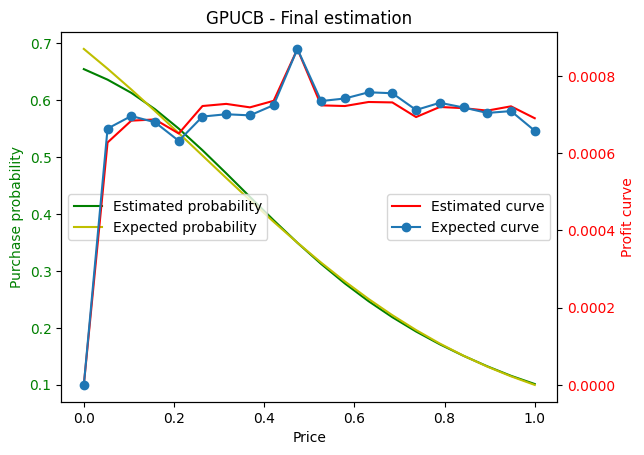

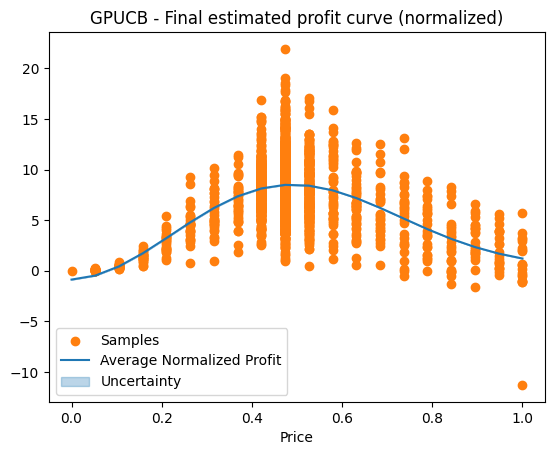

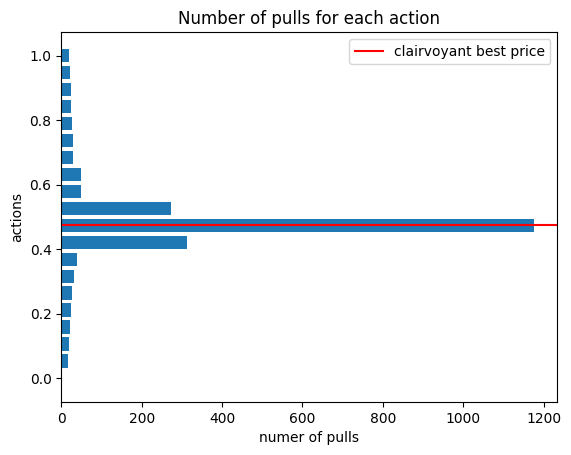

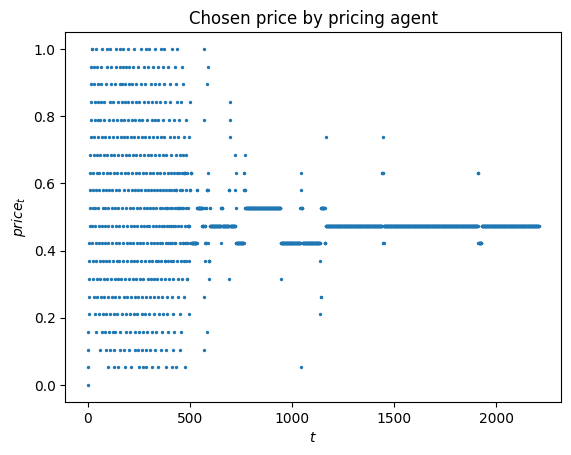

(2190,)
(2189,)


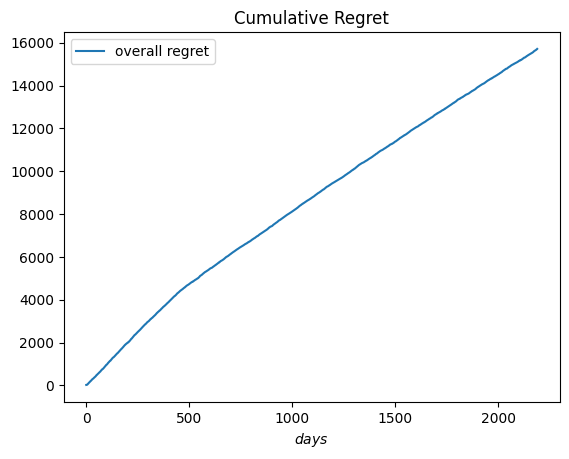

In [23]:

estimated_purchase_probability = (pricing_agent_3.mu_t + pricing_agent_3.beta(pricing_agent_3.t) * pricing_agent_3.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent_3.arms - pricing_agent_3.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent_3.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
# ax1.plot(prices, estimated_profits_per_customer, 'o-', label='estimated_profits_per_customer')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent_3.arms - pricing_agent_3.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent_3.average_customer_percentages*(conversion_probabilities*pricing_agent_3.arms - pricing_agent_3.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist

gp = RBFGaussianProcess(scale=scale)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
# plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();


plt.figure()
plt.barh(prices, pricing_agent_3.N_pulls, height = (prices[1] - prices[0])*0.8)
plt.axhline(y=best_price, color = 'r', linestyle = '-', label = 'clairvoyant best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.title('Number of pulls for each action')
plt.legend()
plt.show();



price_hist = pricing_agent_3.action_hist

plt.figure()
plt.scatter(np.arange(len(price_hist)), price_hist, s=2, label='Chosen price')
plt.xlabel('$t$')
plt.ylabel('$price_t$')
plt.title('Chosen price by pricing agent')
# plt.legend()
plt.show()


clairprofit = np.array(clairvoyant_profits)
bidagentprofit = np.array(bidding_agent_profits)
print(clairprofit.shape)
print(bidagentprofit.shape)

cumulative_regret = np.cumsum(clairprofit[1:]-bidagentprofit)

plt.figure()
plt.plot(cumulative_regret, label="overall regret")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$days$')
plt.show();


### 365*6 rounds - UCB with Negative Feedback bidder (scale = 0.1)

In [24]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

np.random.seed(2)

# product
min_price, max_price = 10, 20
production_cost = 10
price_discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(production_cost, min_price, max_price)  # equals to scaled_min_price

# Pricing Environment and Agent
# Logistic model example
model='logistic'
alpha=0.8
beta=-3
scale=2
TotalDays = 365 * 6
pricing_env = StochasticPricingEnvironment(model, alpha, beta)
pricing_agent_3 = GPUCBAgent(TotalDays, scaled_min_price, scaled_max_price, discretization=price_discretization, scale=scale)
n_customers_t = 0        # to be determined every day after bidding
# for clairvoyant's use
prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)


# Bidding Environment parameters
n_users = 10000
n_competitors = 2
ctrs = np.ones(n_competitors+1)
B = 100
auction = SecondPriceAuction(ctrs)
bidding_agent_profits = []
clairvoyant_profits = []

# Foreach day
for day in range(TotalDays):
    # pricing agent sets the price of the day
    p_t, purchase_probability_t, average_bid_cost_t = pricing_agent_3.pull_arm()

    # Bidding Environment
    bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

    # Bidding Agents
    my_valuation_t = p_t*purchase_probability_t # equals to daily_set_price (which took into account the production cost)

    # Exploratory round to estimate the purchase probability of each price
    if(day == 0):
        my_valuation_t = scaled_max_price


    eta = 1/np.sqrt(n_users) # from theory
    # agentMP = MultiplicativePacingAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    # agentCURMP = ContinuousUpdatedRhoMPAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users,
    #                                 eta=eta)
    # agentUCB = UCBAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF = UCBNFAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    agentNF1 = UCBNFAgent(my_valuation_t, B, n_users, range=0.1)    # range works as the hyperparameter in this problem

    bidding_agents = {
        # "Multiplicative Pacing": agentMP,
        # "Continuously updated Rho MP": agentCURMP,
        # "Plain UCB": agentUCB,
        # "UCB with negative feedback": agentNF,
        "UCBNF with range 0.1" : agentNF1
    }

    utilities = np.zeros((len(bidding_agents), n_users))
    my_bids = np.zeros((len(bidding_agents), n_users))
    my_payments = np.zeros((len(bidding_agents), n_users))
    total_wins = np.zeros((len(bidding_agents)))
    bidding_agent_profit=0
    number_sale_t=0

    np.random.seed(day)
    for u in range(n_users):
        # bidding process
        for idx, (name, agent) in enumerate(bidding_agents.items()):
            my_bid = agent.bid()
            winners, m_t = bidding_env.round(u, my_bid)
            my_win = int(winners==n_competitors)
            f_t, c_t = (my_valuation_t-m_t)*my_win, m_t*my_win
            agent.update(f_t, c_t)
            utilities[idx,u] = f_t
            my_bids[idx,u] = my_bid
            my_payments[idx,u] = c_t
            total_wins[idx] += my_win
    if(total_wins[0] != 0):
        n_customers_t = total_wins[0]
        scaled_payed_bid_per_user = np.sum(my_payments[0,:]) / total_wins[0]


    # Update pricing agent
    # Exploratory round to estimate purchase probability
    if(day == 0):
        original_a_t = pricing_agent_3.a_t
        customers_per_price = int(n_customers_t / price_discretization)
        for idx, price in enumerate(pricing_agent_3.arms):
            sales_per_price = pricing_env.round(price, customers_per_price)
            pricing_agent_3.a_t = idx
            pricing_agent_3.update(sales_per_price, customers_per_price)
            # print(f'Price # {idx} : {price} with {sales_per_price}/{customers_per_price} sales')
        pricing_agent_3.a_t = original_a_t
    # Normal rounds
    else:
        number_sale_t = pricing_env.round(p_t, n_customers_t)
        pricing_agent_3.update(number_sale_t, n_customers_t, scaled_payed_bid_per_user, n_customers_t/n_users)
        bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
        bidding_agent_profits.append(bidding_agent_profit)

    print(day)


# Clairvoyant utility computation

# exploit pricing agent's history to compute best price
price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist
cgp = RBFGaussianProcess(scale=scale).fit(price_hist, profits)
mu, sigma = cgp.predict(prices)
best_price_idx = np.argmax(mu+sigma)
best_price = prices[best_price_idx]
clairvoyant_valuation = best_price * conversion_probabilities[best_price_idx]

clairvoyant_profits = []
for day in range(TotalDays):
  bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

  clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, clairvoyant_valuation)
  clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
  clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[best_price_idx])
  clairvoyant_profit = clairvoyant_sales*best_price - np.sum(clairvoyant_payments)

  clairvoyant_profits.append(clairvoyant_profit)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

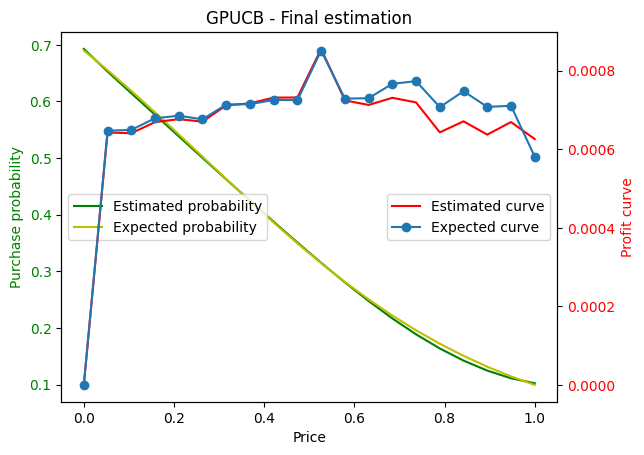

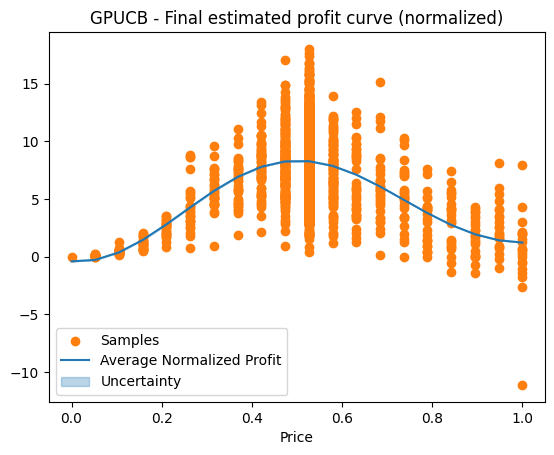

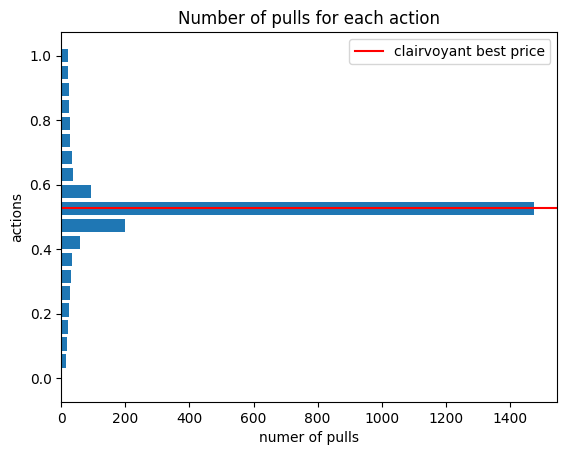

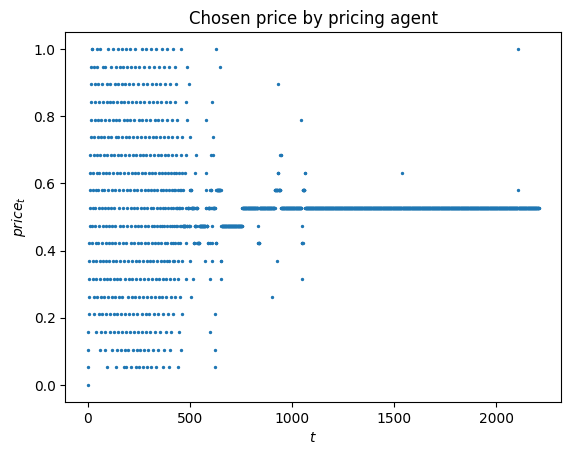

(2190,)
(2189,)


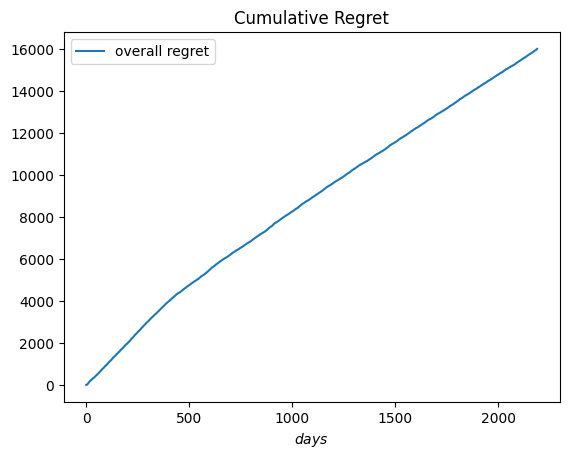

In [25]:

estimated_purchase_probability = (pricing_agent_3.mu_t + pricing_agent_3.beta(pricing_agent_3.t) * pricing_agent_3.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent_3.arms - pricing_agent_3.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent_3.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
# ax1.plot(prices, estimated_profits_per_customer, 'o-', label='estimated_profits_per_customer')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent_3.arms - pricing_agent_3.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent_3.average_customer_percentages*(conversion_probabilities*pricing_agent_3.arms - pricing_agent_3.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.title('GPUCB - Final estimation')
plt.show()

price_hist = pricing_agent_3.action_hist
profits = pricing_agent_3.reward_hist

gp = RBFGaussianProcess(scale=scale)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
# plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();


plt.figure()
plt.barh(prices, pricing_agent_3.N_pulls, height = (prices[1] - prices[0])*0.8)
plt.axhline(y=best_price, color = 'r', linestyle = '-', label = 'clairvoyant best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.title('Number of pulls for each action')
plt.legend()
plt.show();



price_hist = pricing_agent_3.action_hist

plt.figure()
plt.scatter(np.arange(len(price_hist)), price_hist, s=2, label='Chosen price')
plt.xlabel('$t$')
plt.ylabel('$price_t$')
plt.title('Chosen price by pricing agent')
# plt.legend()
plt.show()


clairprofit = np.array(clairvoyant_profits)
bidagentprofit = np.array(bidding_agent_profits)
print(clairprofit.shape)
print(bidagentprofit.shape)

cumulative_regret = np.cumsum(clairprofit[1:]-bidagentprofit)

plt.figure()
plt.plot(cumulative_regret, label="overall regret")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$days$')
plt.show();
